first do the setup

In [1]:

# Check python version
import sys
print('Python version: ',sys.version)
#Print TF version and GPU stats
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi
#install fastai
!pip install -Uqq fastai
#install pytorch
!pip install -Uqq torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
#import numpy
import numpy as np
#import torch
import torch
import torch.nn.functional as F
import torch.nn as nn

#import fastai
from fastai.imports import *
import fastai
from fastai.vision.all import *

from torchvision.models import *

Python version:  3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
TensorFlow version: 2.4.0
Found GPU at: /device:GPU:0

Tue Jan 19 15:50:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    55W / 149W |    133MiB / 11441MiB |      1%      Default |
|                               |                      |                 ERR! |
+-------------------------------+-----------

In [2]:
#parameters for the data
#use the imagewoof dataset
WOOF = True
#augment the data in a random basic way
DATA_AUGMENTATION = False
#erase parts of the images
ERASE_AUGMENTATION = False
#normalize the batch
BATCH_NORMALISATION = False

get the data

In [3]:
#first unpack the data and print some stats
if WOOF:
  path = untar_data(URLs.IMAGEWOOF)
else:
  path = untar_data(URLs.IMAGENETTE)

files = get_image_files(path/"train")
print("Training images: ", len(get_image_files(path/"train")),'(' ,np.round(len(get_image_files(path/"train"))*100/len(get_image_files(path)),2), '%)')
print("Validation images: ", len(get_image_files(path/"val")),'(' ,np.round(len(get_image_files(path/"val"))*100/len(get_image_files(path)),2), '%)')


Training images:  9025 ( 69.67 %)
Validation images:  3929 ( 30.33 %)


label data

In [4]:
#create dict to show better readable labels
if WOOF:
  lbl_dict = dict(
      n02086240= 'Shih-Tzu',
      n02087394= 'Rhodesian ridgeback',
      n02088364= 'Beagle',
      n02089973= 'English foxhound',
      n02093754= 'Australian terrier',
      n02096294= 'Border terrier',
      n02099601= 'Golden retriever',
      n02105641= 'Old English sheepdog',
      n02111889= 'Samoyed',
      n02115641= 'Dingo'
    )
else:
  lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
  )
#function to return human readable filenames
def label_func(fname):
  return lbl_dict[parent_label(fname)]

create model with its training and learning paarmeters

In [5]:
#define the used model (here an optimized xresnet50)
model = xresnext50(n_out=10, sa=True, pool=MaxPool)

#add further layers here
#model.fc = nn.Sequential(    
#)

#the used optimization function, here ranger
optimizer = partial(ranger, mom=.95, sqr_mom=.99, eps=1e-6)

#additional model callbacks, if needed
callbacks = []
#callbacks = [SaveModelCallback()]

#the Learning Rate
LEARNING_RATE = 8e-3
EPOCHS = 20

test sth

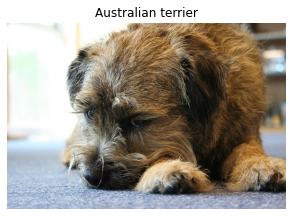

In [6]:
#get all the images
fnames = get_image_files(path)
#create a image
PILImage.create(fnames[0])
#create category pipeline
tfm = Pipeline([parent_label, lbl_dict.__getitem__, Categorize(vocab = lbl_dict.values())])
tfm(fnames[0])
#create splitter
split = GrandparentSplitter(valid_name='val')(fnames)
#create dataset
dset = Datasets(fnames, 
                [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize(vocab = lbl_dict.values())]],
                splits=split)
dset.show(dset[0])

transform data


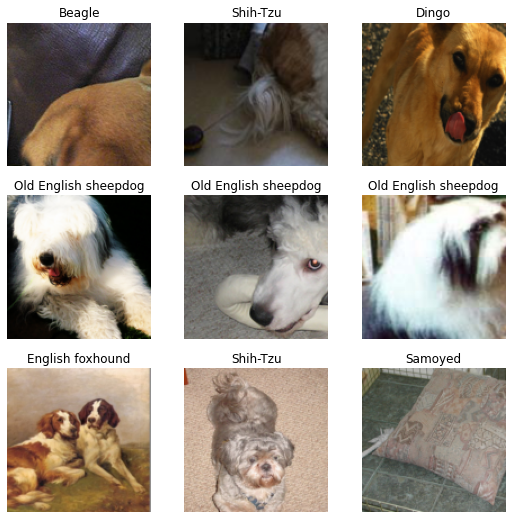

In [7]:
#add the item transformations (just resize and crop)
item_tfms = [RandomResizedCrop(128),ToTensor()]
#the batch transformations (mainly normalize)
batch_tfms = [IntToFloatTensor()]
if DATA_AUGMENTATION:
  add_tfms = []
  if ERASE_AUGMENTATION:
    add_tfms=[RandomErasing()]
  batch_tfms = [IntToFloatTensor(),*aug_transforms(mult=2,xtra_tfms=add_tfms)]
if BATCH_NORMALISATION:
  batch_tfms.append(Normalize.from_stats(*imagenet_stats))
      
#create the dataloader
dls = dset.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)
dls.show_batch()

Learn

In [8]:
#mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
for x in [0.0, 0.2, 0.4, 0.6]:
  #redefine
  model = xresnext50(n_out=10, sa=True, pool=MaxPool)
  dls = dset.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)
  optimizer = partial(ranger, mom=.95, sqr_mom=.99, eps=1e-6)

  #add final dropout layer post-sc
  model.fc = nn.Sequential(  
      nn.Dropout(x),  
      #nn.Linear(10, 10)
  )

  # dropout via forward
  #model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))
 
  #add teh csv logger
  callbacks = [CSVLogger(fname='model_logs_dropout_'+str(x-int(x))[2:]+'_20_epochs.csv'),ShowGraphCallback()]
  #define the learner
  learn = Learner(dls, model, opt_func=optimizer, metrics=[accuracy, lambda i,t: top_k_accuracy(i,t,k=2), lambda i,t: top_k_accuracy(i,t,k=3)], cbs=callbacks, path = '/content/gdrive/MyDrive/DL/logs')

  #do the train with variable learning rates
  learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
  #print the results
  learn.show_results()

ModuleAttributeError: ignored

In [ ]:
#get the learning rate
#learn.lr_find()

And the code to keep the colab open

In [ ]:
#cl = () => {console.log('refreshing'); document.querySelector('colab-connect-button').click()}